# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

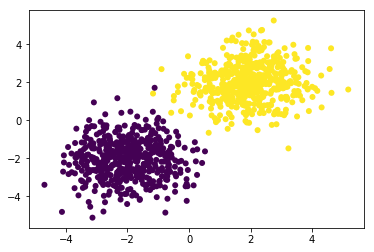

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

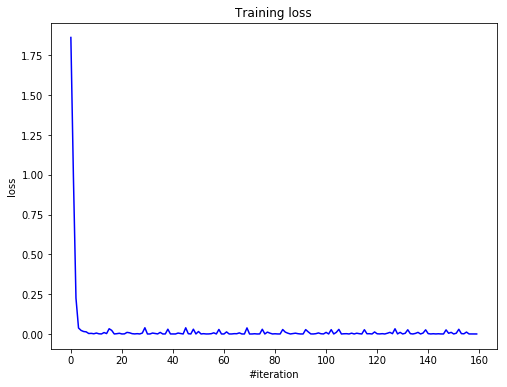

Current loss: 0.000043


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [52]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [53]:
# Your code goes here. ################################################
n_classes = 10
n_hidden = 1000

def one_hot(y):
    n = y.shape[0]
    one_hot = np.zeros((n, n_classes), dtype=np.float32)
    one_hot[np.arange(n), y] = 1
    return one_hot

# Save for later
y_train_original = y_train.copy()
y_val_original = y_val.copy()
y_test_original = y_test.copy()

y_train = one_hot(y_train)
y_val = one_hot(y_val)
y_test = one_hot(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***
- Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between test and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***


In [10]:
# Your code goes here. ################################################

### Compare activation functions

In [11]:
net_ReLU = Sequential()
net_ReLU.add(Linear(28*28, n_hidden))
net_ReLU.add(ReLU())
net_ReLU.add(Linear(n_hidden, 10))
net_ReLU.add(LogSoftMax())

print(net_ReLU)

Linear 784 -> 1000
ReLU
Linear 1000 -> 10
LogSoftMax



In [12]:
net_ELU = Sequential()
net_ELU.add(Linear(28*28, n_hidden))
net_ELU.add(ELU())
net_ELU.add(Linear(n_hidden, 10))
net_ELU.add(LogSoftMax())

print(net_ELU)

Linear 784 -> 1000
ELU
Linear 1000 -> 10
LogSoftMax



In [13]:
net_LeakyReLU = Sequential()
net_LeakyReLU.add(Linear(28*28, n_hidden))
net_LeakyReLU.add(LeakyReLU())
net_LeakyReLU.add(Linear(n_hidden, 10))
net_LeakyReLU.add(LogSoftMax())

print(net_LeakyReLU)

Linear 784 -> 1000
LeakyReLU
Linear 1000 -> 10
LogSoftMax



In [14]:
net_SoftPlus = Sequential()
net_SoftPlus.add(Linear(28*28, n_hidden))
net_SoftPlus.add(SoftPlus())
net_SoftPlus.add(Linear(n_hidden, 10))
net_SoftPlus.add(LogSoftMax())

print(net_SoftPlus)

Linear 784 -> 1000
SoftPlus
Linear 1000 -> 10
LogSoftMax



In [54]:
criterion = ClassNLLCriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1024

In [16]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx].reshape((X[batch_idx].shape[0], -1)), Y[batch_idx]

In [17]:
def train(net, adam=False, contrastiveCriterion=False):
    loss_history = {'train': [], 'val': []}
    
    t0 = time()
    
    steps_in_epoch = np.ceil(y_train.shape[0] / batch_size)
    
    for i in range(n_epoch):
        
        net.training = True
        
        if contrastiveCriterion == True:
            y_train_ = y_train_original
        else:
            y_train_ = y_train
        
        for x_batch, y_batch in get_batches((X_train, y_train_), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch.reshape((x_batch.shape[0], -1)), dp)

            # Update weights
            if adam == False:
                sgd_momentum(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)
            else:
                adam_optimizer(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)

            loss_history['train'].append(loss)
        
        # Validation loss.
        net.training = False
        
        x_validation = X_val.reshape((X_val.shape[0], -1))
        y_validation = y_val_original if contrastiveCriterion else y_val
            
        # Forward
        predictions = net.forward(x_validation)
        loss_v = criterion.forward(predictions, y_validation)
        loss_history['val'].append([steps_in_epoch * (i + 1), loss_v])
        
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history['train'], 'b', label='Training loss')
        plt.plot(np.array(loss_history['val'])[:,0], np.array(loss_history['val'])[:,1], 'r', label='Validation loss')
        plt.grid()
        plt.yscale('log')
        plt.legend()
        plt.show()

        print('Current training loss: %f' % loss)
        print('Current validation loss: %f' % loss_v)
    
    average_time = (time() - t0) / n_epoch
    print('Average time per epoch: %.2f sec' % average_time)
    
    return loss_history, average_time

In [18]:
loss_history = {}
average_time = {}

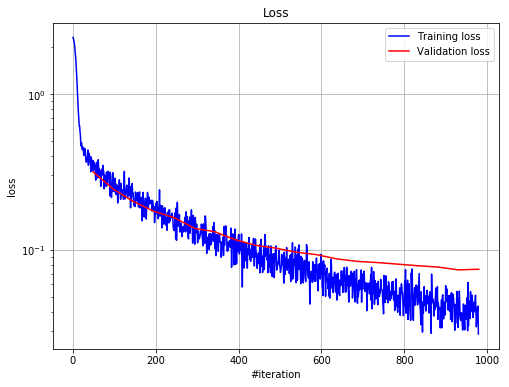

Current training loss: 0.028724
Current validation loss: 0.074868
Average time per epoch: 1.54 sec


In [19]:
optimizer_state = {}

loss_history['ReLU'], average_time['ReLU'] = train(net_ReLU)

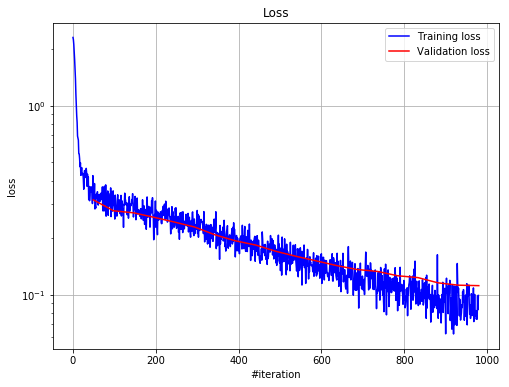

Current training loss: 0.099008
Current validation loss: 0.111532
Average time per epoch: 2.18 sec


In [20]:
optimizer_state = {}

loss_history['ELU'], average_time['ELU'] = train(net_ELU)

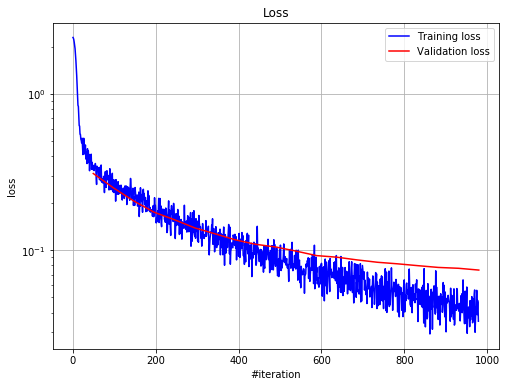

Current training loss: 0.035215
Current validation loss: 0.074783
Average time per epoch: 2.15 sec


In [21]:
optimizer_state = {}

loss_history['LeakyReLU'], average_time['LeakyReLU'] = train(net_LeakyReLU)

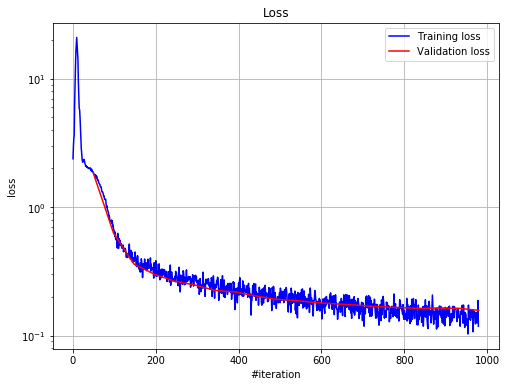

Current training loss: 0.118140
Current validation loss: 0.157053
Average time per epoch: 1.35 sec


In [22]:
optimizer_state = {}

loss_history['SoftPlus'], average_time['SoftPlus'] = train(net_SoftPlus)

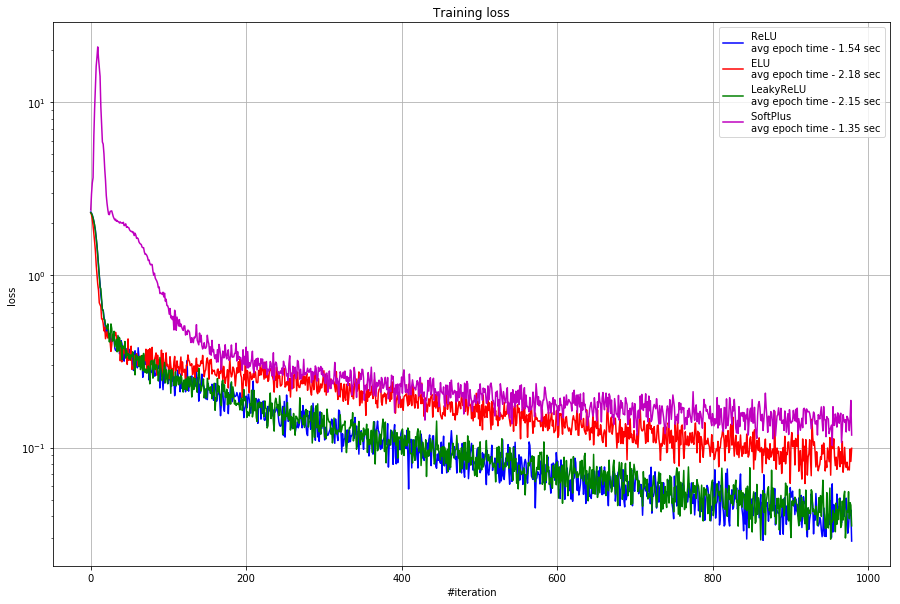

In [23]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(15, 10))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history['ReLU']['train'], 'b', label='ReLU \navg epoch time - %.2f sec' % (average_time['ReLU']))
plt.plot(loss_history['ELU']['train'], 'r', label='ELU \navg epoch time - %.2f sec' % (average_time['ELU']))
plt.plot(loss_history['LeakyReLU']['train'], 'g', label='LeakyReLU \navg epoch time - %.2f sec' % (average_time['LeakyReLU']))
plt.plot(loss_history['SoftPlus']['train'], 'm', label='SoftPlus \navg epoch time - %.2f sec' % (average_time['SoftPlus']))
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

#### Analysis
ReLU and LeakyReLU reached the best loss over 20 epochs. They seem to produce very close results, so (at least, for this kind of networks) I prefer ReLU - it is simpler than LeakyReLU. ReLU was also faster than LeakyReLU, which can be explained by its simplicity. ELU was close to these two at the begining, but they bit it. SoftPlus reached the worst value of training loss. It also has an interesting behaviour during first couple of epochs as can be seen on the plot. It was the quickest but this does not justify the drop in performance - ReLU was only about 15% slower. Validation loss for these four activation functions follows the same pattern.

### Add BatchNorm

Here I used the net with ReLU only.

In [24]:
net_ReLU = Sequential()
net_ReLU.add(Linear(28*28, n_hidden))
net_ReLU.add(BatchNormalization())
net_ReLU.add(ChannelwiseScaling(n_hidden))
net_ReLU.add(ReLU())
net_ReLU.add(Linear(n_hidden, 10))
net_ReLU.add(LogSoftMax())

print(net_ReLU)

Linear 784 -> 1000
BatchNormalization
ChannelwiseScaling
ReLU
Linear 1000 -> 10
LogSoftMax



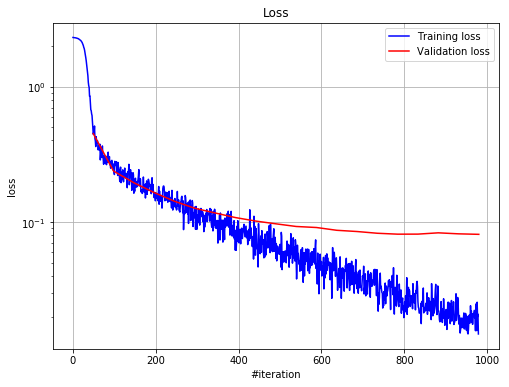

Current training loss: 0.014931
Current validation loss: 0.081181
Average time per epoch: 2.30 sec


In [25]:
optimizer_state = {}

loss_history['ReLU_bn'], average_time['ReLU_bn'] = train(net_ReLU)

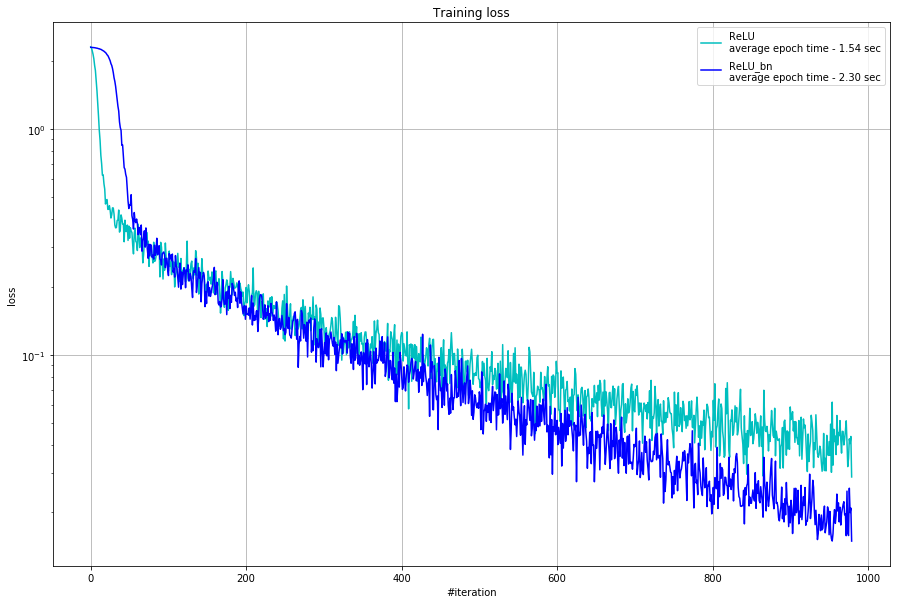

In [26]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(15, 10))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history['ReLU']['train'], 'c', label='ReLU \naverage epoch time - %.2f sec' % (average_time['ReLU']))
plt.plot(loss_history['ReLU_bn']['train'], 'b', label='ReLU_bn \naverage epoch time - %.2f sec' % (average_time['ReLU_bn']))
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

#### Analysis

While the network became 20-25% slower in training, batch normalization improved the training speed. A lower value of training loss was reached after several epochs. At the begining though, the net without BN was quicker.
Interestingly, validation loss for the net with BN is slightly worse. It may be a random occurance or not - the difference is quite small.

### Momentum_sgd vs Adam

In [55]:
loss_history = {}
average_time = {}

In [56]:
net_sgd = Sequential()
net_sgd.add(Linear(28*28, n_hidden))
net_sgd.add(ReLU())
net_sgd.add(Linear(n_hidden, 10))
net_sgd.add(LogSoftMax())

print(net_ReLU)

Linear 784 -> 3000
ReLU
Linear 3000 -> 10
LogSoftMax



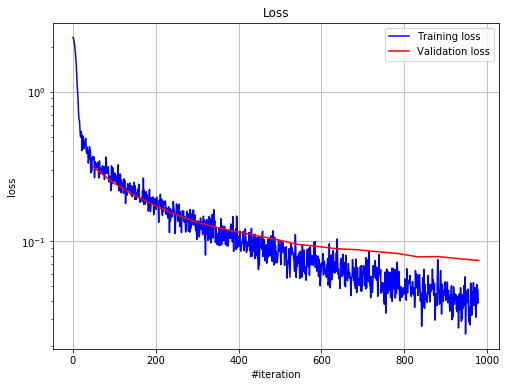

Current training loss: 0.038933
Current validation loss: 0.074395
Average time per epoch: 1.47 sec


In [57]:
optimizer_state = {}

loss_history['sgd'], average_time['sgd'] = train(net_sgd)

In [58]:
net_adam = Sequential()
net_adam.add(Linear(28*28, n_hidden))
net_adam.add(ReLU())
net_adam.add(Linear(n_hidden, 10))
net_adam.add(LogSoftMax())

print(net_ReLU)

Linear 784 -> 3000
ReLU
Linear 3000 -> 10
LogSoftMax



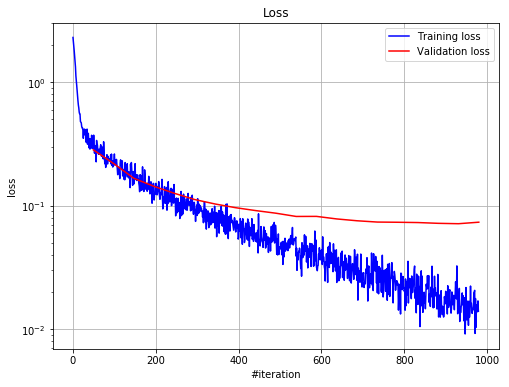

Current training loss: 0.013983
Current validation loss: 0.073603
Average time per epoch: 1.57 sec


In [59]:
optimizer_state = {}

# optimizer_config = {}
optimizer_config['learning_rate'] = 1e-3
optimizer_config['beta1'] = 0.9
optimizer_config['beta2'] = 0.999
optimizer_config['epsilon'] = 1e-8

loss_history['adam'], average_time['adam'] = train(net_adam, adam=True)

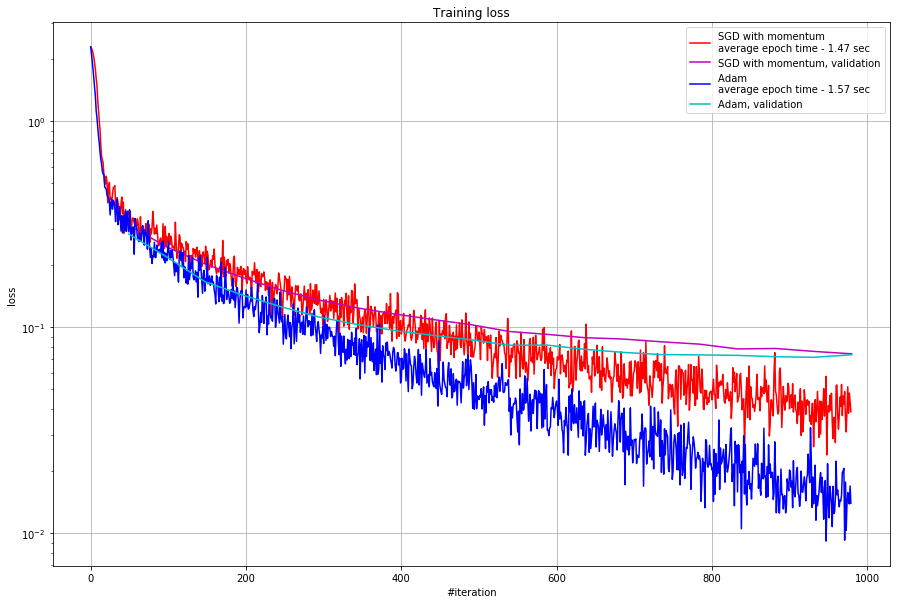

In [62]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(15, 10))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history['sgd']['train'], 'r', label='SGD with momentum \naverage epoch time - %.2f sec' % (average_time['sgd']))
plt.plot(np.array(loss_history['sgd']['val'])[:,0], np.array(loss_history['sgd']['val'])[:,1], 'm', label='SGD with momentum, validation')
plt.plot(loss_history['adam']['train'], 'b', label='Adam \naverage epoch time - %.2f sec' % (average_time['adam']))
plt.plot(np.array(loss_history['adam']['val'])[:,0], np.array(loss_history['adam']['val'])[:,1], 'c', label='Adam, validation')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [78]:
# Accuracies

y_pred_sgd = net_sgd.forward(X_val.reshape((X_val.shape[0], -1))).argmax(axis=1)
y_pred_adam = net_adam.forward(X_val.reshape((X_val.shape[0], -1))).argmax(axis=1)

sgd_acc = np.sum(y_pred_sgd == y_val_original) / y_val_original.shape[0]
adam_acc = np.sum(y_pred_adam == y_val_original) / y_val_original.shape[0]

print('SDG accuracy: %.3f' % sgd_acc)
print('Adam accuracy: %.3f' % adam_acc)

SDG accuracy: 0.978
Adam accuracy: 0.979


#### Analysis

Adam is a faster converging optimization algorithm then SGD with momentum in this case (and most other cases). Validation loss was lower for Adam most of the time. At the end, however, SGD validation loss almost cought up with the Adam's loss. Same for accuracies = they are almost identical eventually. Overal, Adam performs better and is faster.

### Dropout

In [83]:
# Increasing number of parameters:
n_hidden = 3000

loss_history = {}

In [84]:
# No dropout
net_ReLU = Sequential()
net_ReLU.add(Linear(28*28, n_hidden))
net_ReLU.add(ReLU())
net_ReLU.add(Linear(n_hidden, 10))
net_ReLU.add(LogSoftMax())

print(net_ReLU)

Linear 784 -> 3000
ReLU
Linear 3000 -> 10
LogSoftMax



In [85]:
# dropout
net_ReLU_dropout = Sequential()
net_ReLU_dropout.add(Linear(28*28, n_hidden))
net_ReLU_dropout.add(Dropout())
net_ReLU_dropout.add(ReLU())
net_ReLU_dropout.add(Linear(n_hidden, 10))
net_ReLU_dropout.add(LogSoftMax())

print(net_ReLU_dropout)

Linear 784 -> 3000
Dropout
ReLU
Linear 3000 -> 10
LogSoftMax



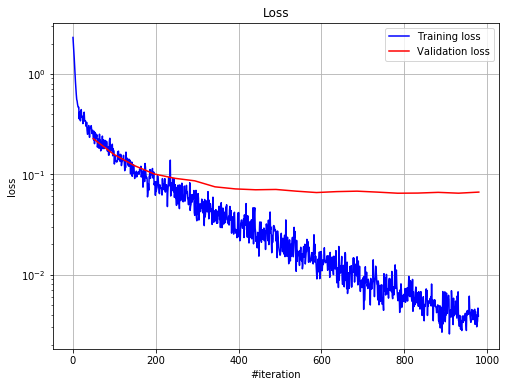

Current training loss: 0.003868
Current validation loss: 0.066356
Average time per epoch: 4.52 sec


In [86]:
optimizer_state = {}

loss_history['ReLU'], average_time['ReLU'] = train(net_ReLU, adam=True)

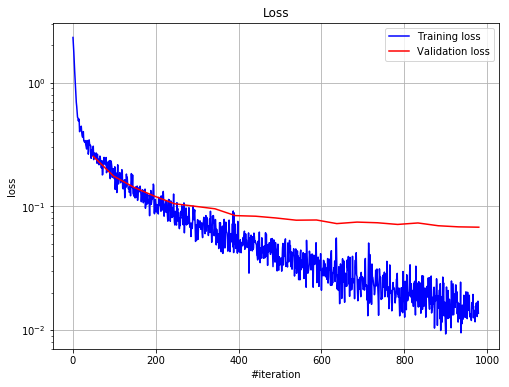

Current training loss: 0.013633
Current validation loss: 0.067797
Average time per epoch: 9.38 sec


In [87]:
optimizer_state = {}

loss_history['ReLU_dropout'], average_time['ReLU_dropout'] = train(net_ReLU_dropout, adam=True)

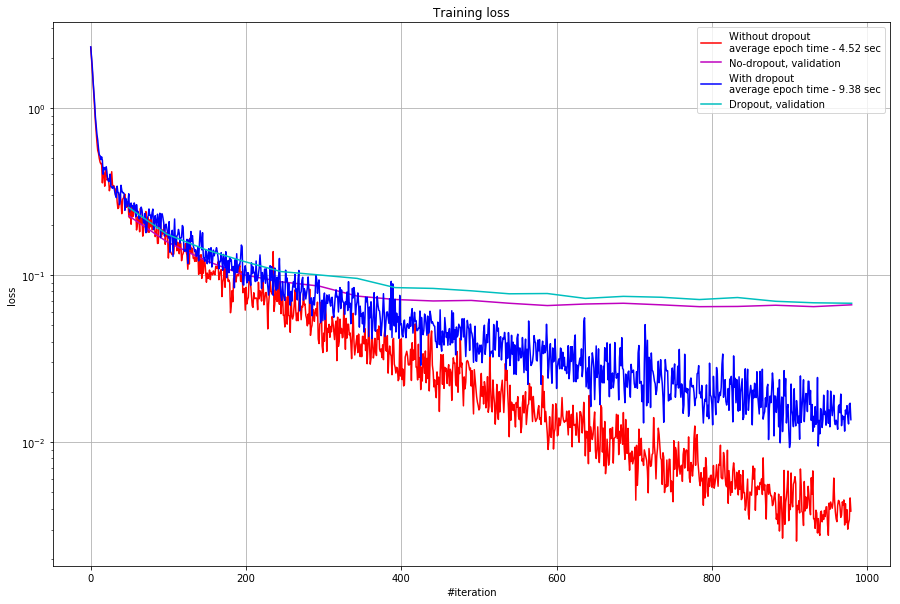

In [89]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(15, 10))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history['ReLU']['train'], 'r', label='Without dropout \naverage epoch time - %.2f sec' % (average_time['ReLU']))
plt.plot(np.array(loss_history['ReLU']['val'])[:,0], np.array(loss_history['ReLU']['val'])[:,1], 'm', label='No-dropout, validation')
plt.plot(loss_history['ReLU_dropout']['train'], 'b', label='With dropout \naverage epoch time - %.2f sec' % (average_time['ReLU_dropout']))
plt.plot(np.array(loss_history['ReLU_dropout']['val'])[:,0], np.array(loss_history['ReLU_dropout']['val'])[:,1], 'c', label='Dropout, validation')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [90]:
# Accuracies

y_pred_no_dropout = net_ReLU.forward(X_val.reshape((X_val.shape[0], -1))).argmax(axis=1)
y_pred_dropout = net_ReLU_dropout.forward(X_val.reshape((X_val.shape[0], -1))).argmax(axis=1)

no_dropout_acc = np.sum(y_pred_no_dropout == y_val_original) / y_val_original.shape[0]
dropout_acc = np.sum(y_pred_dropout == y_val_original) / y_val_original.shape[0]

print('No-dropout net accuracy: %.3f' % no_dropout_acc)
print('Dropout net accuracy: %.3f' % dropout_acc)

No-dropout net accuracy: 0.982
Dropout net accuracy: 0.980


#### Analysis

For some reason, in this case the net without dropout performed better then the one with it both in terms of train and val loss. At the end, they almost leveled up in validation accuracy.
In general, I expected an opposite result. I think, dropout works better for deeper networks.

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

ContrastiveCriterion does not require one-hot encoded labels

In [36]:
criterion = ClassContrastiveCriterion(10)

In [37]:
n_hidden = 512

# No dropout
net = Sequential()
net.add(Linear(28*28, n_hidden))
net.add(ReLU())
net.add(Linear(n_hidden, 128))
net.add(ReLU())

print(net)

Linear 784 -> 512
ReLU
Linear 512 -> 128
ReLU



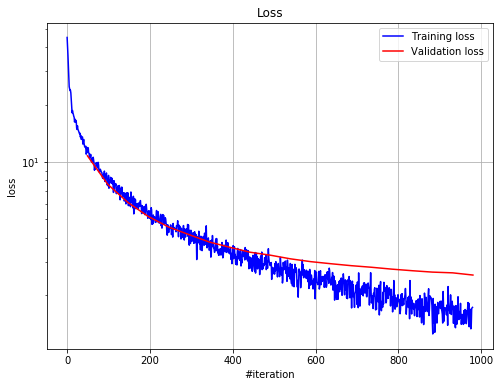

Current training loss: 1.723181
Current validation loss: 2.547069
Average time per epoch: 38.67 sec


In [38]:
optimizer_state = {}

loss_history['net'], average_time['net'] = train(net, adam=True, contrastiveCriterion=True)

/home/viktor/anaconda3/envs/cs231n/lib/python3.6/site-packages/scipy/spatial/kdtree.py:74: RuntimeWarning: invalid value encountered in sqrt
  return minkowski_distance_p(x, y, p)**(1./p)


5006741.0 44988259.0


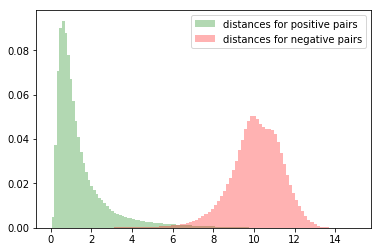

In [39]:
#features : 'number of examples' * 'dimensionality'
f = net.forward(X_val.reshape((X_val.shape[0], -1)))#<YOUR CODE GOES HERE>
labels = y_val_original

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))

The area of intersaction is very low which means good clasterisation. We almost always can distinguish positive pairs from negative by the Bhattacharyya coefficients.